# Identifying audio with RNN

In this notebook we'll experiment with classifying a MFCCs with RNN.

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def split_data(features, labels, test_size=0.2, val_size=0.2, random_state=None):
    # input features (numpy array / MFCCs)
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    
    # Further split training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size/(1-test_size), random_state=random_state)
    
    return X_train, y_train, X_val, y_val, X_test, y_test


In [3]:
import os
import numpy as np
import librosa

# Load audio files and extract MFCCs
audio_files = ['piano_c3.wav', 'riddim_screech.wav', 'violin_c4.wav']
mfccs_list = []
labels = []

for audio_file in audio_files:
    y, sr = librosa.load("/Users/helvetica/SignalProcessing/data/one-shots/" + audio_file, sr=None)  # sr=None to keep the original sampling rate
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract MFCCs
    mfccs_list.append(mfccs.T)  # Transpose to match shape for split_data
    track_name = os.path.splitext(os.path.basename(audio_file))[0]  # Extract track name from file name
    labels += [track_name] * mfccs.shape[1]  # Add track name as label

# Convert lists to numpy arrays
features = np.concatenate(mfccs_list, axis=0)
labels = np.array(labels)

# Split data into training, validation, and test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(features, labels)

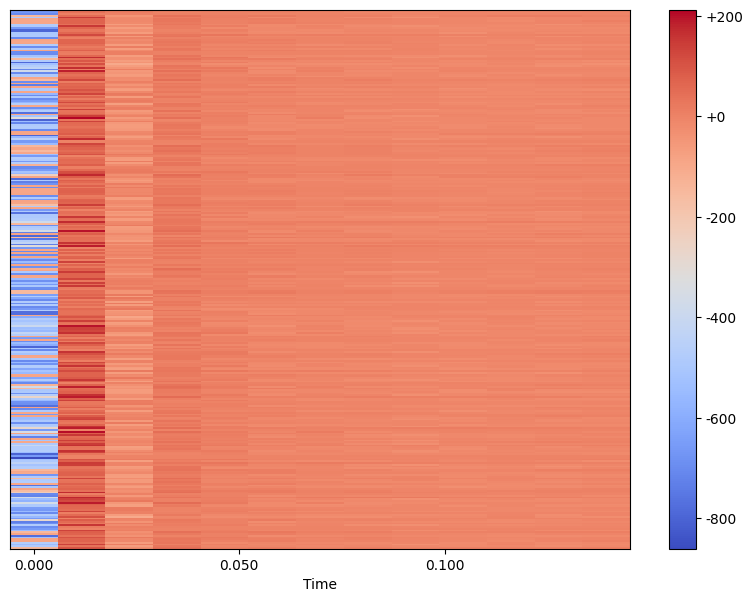

(311, 13)


In [15]:
plt.figure(figsize=(10, 7))
librosa.display.specshow(X_train, x_axis="time", sr=sr)
plt.colorbar(format="%+2.f")
plt.show()
print(X_train.shape)

There are 311 frames of audio data in our training set, and for each frame, we have computed 13 MFCC coefficients.

In [48]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Assuming 1 MFCC coefficient per time step
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1) 
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [49]:
X_train.shape

(311, 13, 1)

In [50]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder on the target labels and transform them
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Ensure that the number of classes is correct
num_classes = len(label_encoder.classes_)

# Convert integer labels to one-hot encoded categorical labels
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_categorical = to_categorical(y_val_encoded, num_classes=num_classes)

In [51]:
y_train_categorical.shape

(311, 3)

In [52]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
from keras.optimizers import Adam


# Define input layer with the desired input shape
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)

model = Sequential()

# Add LSTM layer with 128 units
model.add(LSTM(units=128))

# Add dropout layer to prevent overfitting
model.add(Dropout(0.3))

# Add output layer with softmax activation for multi-class classification
model.add(Dense(units=num_classes, activation='softmax'))

# Compile model
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, validation_data=(X_val, y_val_categorical))

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6340 - loss: 0.8812 - val_accuracy: 0.7692 - val_loss: 0.5898
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8480 - loss: 0.5209 - val_accuracy: 0.9423 - val_loss: 0.3266
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9531 - loss: 0.2691 - val_accuracy: 0.9712 - val_loss: 0.1475
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9854 - loss: 0.1077 - val_accuracy: 0.9808 - val_loss: 0.0923
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0617 - val_accuracy: 0.9808 - val_loss: 0.0971
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9945 - loss: 0.0327 - val_accuracy: 0.9808 - val_loss: 0.1068
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9982 - loss: 0.0219 - val_accuracy: 0.9808 - val_loss: 0.0895
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9973 - loss: 0.0163 - val_accuracy: 0.9808 - v

In [53]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,843 (784.55 KB)

 Trainable params: 66,947 (261.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,896 (523.04 KB)

In [54]:
# Save trained model
model.save("RNN_0.keras")

# Save label encoder
np.save("RNN_0_label_encoder.npy", label_encoder.classes_)

In [55]:
from keras.utils import to_categorical

# Convert integer labels to one-hot encoded categorical labels for test data
y_test_encoded = label_encoder.transform(y_test)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

# Reshape X_test to include the time steps dimension
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# Evaluate model on test data
loss, accuracy = model.evaluate(X_test_reshaped, y_test_categorical)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0152 
Test Loss: 0.017120786011219025, Test Accuracy: 1.0


In [56]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

def preprocess_data(audio_files):
    """
    Preprocesses audio data and prepares it for model prediction.

    Args:
    - audio_files: List of audio file paths

    Returns:
    - preprocessed_data: Preprocessed audio data with shape (num_samples, num_timesteps, num_features)
    """
    mfccs_list = []

    for audio_file in audio_files:
        y, sr = librosa.load(audio_file, sr=None)  # sr=None to keep the original sampling rate
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract MFCCs
        mfccs_list.append(mfccs.T)  # Transpose to match shape for model input

    preprocessed_data = np.concatenate(mfccs_list, axis=0)
    preprocessed_data = preprocessed_data.reshape(preprocessed_data.shape[0], preprocessed_data.shape[1], 1)  # Assuming 1 MFCC coefficient per time step

    return preprocessed_data

def predict_on_new_data(model, new_data):
    """
    Predicts labels for new data using a trained model.

    Args:
    - model: Trained Keras model
    - new_data: New data for prediction, with shape (num_samples, num_timesteps, num_features)

    Returns:
    - predictions: Predicted labels for the new data
    """
    # Perform prediction on the new data
    predictions = model.predict(new_data)

    # Convert predictions to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    return predicted_labels

# Define paths to audio files
audio_files = ['/Users/helvetica/SignalProcessing/data/one-shots/piano_c3.wav',
               '/Users/helvetica/SignalProcessing/data/one-shots/riddim_screech.wav',
               '/Users/helvetica/SignalProcessing/data/one-shots/violin_tremolo_c4.wav']

# Preprocess new data
preprocessed_data = preprocess_data(audio_files)

# Assuming 'model' is your trained Keras model
# Get predictions
predictions = predict_on_new_data(model, preprocessed_data)

# Print predictions
print(predictions)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

In [57]:
def predict_on_new_data(model, new_data, label_encoder):
    """
    Args:
    - new_data: New data for prediction, with shape (num_samples, num_timesteps, num_features)
    - label_encoder: LabelEncoder object used for encoding labels during training

    Returns:
    - predicted_labels: Predicted labels for the new data
    - predicted_label_names: Predicted label names for the new data
    """

    predictions = model.predict(new_data)

    # Convert predictions to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Map predicted labels to label names
    predicted_label_names = label_encoder.inverse_transform(predicted_labels)

    return predicted_labels, predicted_label_names

# Assuming 'model' is your trained Keras model
# 'new_data' is your new data for prediction
# 'label_encoder' is the LabelEncoder object used during training

# Get predictions
predictions, predicted_label_names = predict_on_new_data(model, preprocessed_data, label_encoder)

# Print predicted labels and corresponding label names
for label, label_name in zip(predictions, predicted_label_names):
    print(f"Predicted Label: {label}, Label Name: {label_name}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 2, Label Name: violin_c4
Predicted Label: 2, Label Name: violin_c4
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label: 0, Label Name: piano_c3
Predicted Label

## Real Time Predictions

In [58]:
import sounddevice as sd
import numpy as np
import librosa

# Function to preprocess audio data
def preprocess_audio(audio_data, sr=44100, n_mfcc=13, hop_length=512, n_fft=2048):
    """
    Preprocesses audio data for prediction.

    Args:
    - audio_data: Audio data as numpy array
    - sr: Sampling rate (default: 44100 Hz)
    - n_mfcc: Number of MFCC coefficients to extract (default: 13)
    - hop_length: Hop length for MFCC calculation (default: 512)
    - n_fft: Number of FFT points for MFCC calculation (default: 2048)

    Returns:
    - preprocessed_data: Preprocessed audio data with shape (num_samples, num_timesteps, num_features)
    """
    # Initialize list to store preprocessed batches
    preprocessed_batches = []

    # Determine the number of samples and the size of each batch
    num_samples = len(audio_data)
    batch_size = 10000  # Choose an appropriate batch size based on your system resources
    
    # Process audio data in batches
    for i in range(0, num_samples, batch_size):
        # Extract MFCC features for the current batch
        mfccs = librosa.feature.mfcc(y=audio_data[i:i+batch_size], sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
        mfccs = mfccs.T  # Transpose to match shape for model input
        preprocessed_batches.append(mfccs)

    # Concatenate preprocessed batches
    preprocessed_data = np.concatenate(preprocessed_batches, axis=0)

    # Reshape data to match model input shape
    preprocessed_data = preprocessed_data.reshape(preprocessed_data.shape[0], preprocessed_data.shape[1], 1)

    return preprocessed_data


# Function to make predictions on audio data
def predict_audio(model, audio_data, label_encoder):
    """
    Predicts labels for audio data using a trained model.

    Args:
    - model: Trained Keras model
    - audio_data: Audio data as numpy array
    - label_encoder: LabelEncoder object used for encoding labels during training

    Returns:
    - predicted_label: Predicted label for the audio data
    - predicted_label_name: Predicted label name for the audio data
    """
    # Preprocess audio data
    preprocessed_data = preprocess_audio(audio_data)

    # Make prediction
    prediction = model.predict(preprocessed_data)

    # Convert prediction to label
    predicted_label = np.argmax(prediction)

    # Print predicted label and classes in label encoder
    print("Predicted Label:", predicted_label)

    # Check if predicted label index is in the LabelEncoder's classes
    if predicted_label < len(label_encoder.classes_):
        # Map predicted label to label name
        predicted_label_name = label_encoder.inverse_transform([predicted_label])[0]
    else:
        # Handle previously unseen label
        predicted_label_name = "Unknown"

    return predicted_label, predicted_label_name



# Define a function to stream audio and make predictions
def stream_audio_and_predict(model, label_encoder, duration=10, samplerate=44100):
    print("Streaming audio...")

    def callback(indata, frames, time, status):
        if status:
            print(status)
        if any(indata):
            # Make prediction on the incoming audio data
            predicted_label, predicted_label_name = predict_audio(model, indata[:, 0], label_encoder)
            
            print(f"Predicted Label: {predicted_label}, Label Name: {predicted_label_name}")

    with sd.InputStream(callback=callback, channels=1, samplerate=samplerate):
        sd.sleep(int(duration * 1000))

# Stream audio and make predictions
stream_audio_and_predict(model, label_encoder)

Streaming audio...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 4
Predicted Label: 4, Label Name: Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Label: 1
Predicted Label: 1, Label Name: riddim_screech


/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/Users/helvetica/SignalProcessing/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
